# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

This notebook implements the custom DBSCAN algorithm on the Wine dataset. Here, DBSCAN is used to discover clusters in dimensionality-reduced data without labels (unsupervised learning). The objective of this task is to validate the use of the custom DBSCAN class, and evaluate its performance for a multi-feature clustering problem.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Wine dataset with relevant features
- Drops outliers, duplicates, and missing data
- Performs PCA for dimensionality reduction
3. **Data Visualization**
- Visualizes the transformed data
4. **DBSCAN Implementation**
- Implements the custom-built DBSCAN algorithm on the data
- Visualizes the results  
- Evaluates the results across multiple metrics  
5. **DBSCAN Implementation (Changing Parameters)**
- Implements the custom-built DBSCAN algorithm with various epsilon values and minimum neighbors for a core point
- Examines the effect on model performance
6. **Comparison with Existing Models**
- Runs the scikit-learn version of DBSCAN
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the DBSCAN clustering algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run DBSCAN. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Sklearn 1.6.1

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rice_ml.preprocess import *
from rice_ml.unsupervised_learning.clustering import *
from rice_ml.unsupervised_learning.pca import *
from rice_ml.postprocess.unsupervised import *
import sklearn

### Data Loading & Cleaning
*Loading and preprocessing data*

The data used in this notebook comes from the Wine dataset. Although this dataset is typically used for either supervised regression or classification, it contains fairly sizable number of features that make it suitable for clustering algorithms to explore relationships in the data. Additionally, it allows for several data cleaning steps that showcase the `rice_ml` preprocessing modules, as well as dimensionality reduction using the `PCA` class.

The data is first loaded as a Pandas DataFrame.

In [44]:
# Loading the data
wine_data = sklearn.datasets.load_wine(as_frame = True)
wine_data = wine_data.frame
display(wine_data)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


To ensure that the dataset does not contain missing data, we apply a series of preprocessing steps using functions from the `preprocessing` package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another. In addition, we drop the column with the *target* variable.

In [45]:
# Cleaning the data (removing missing data, outliers, or duplicate rows)
wine_data_missing = missing_data(wine_data, 'drop')
wine_data_outliers = outlier_identify(wine_data_missing, 'zscore', drop = True)
wine_data_cleaned = duplicate_identify(wine_data_missing[:, :-1], True)

Because DBSCAN is an unsupervised learning technique, there is no meaningful distinction between the feature data and a target. Thus, the dataset does not need to be further divided. However, because there are many features in this set, we apply PCA with three components to reduce the dimensionality and facilitate analysis. For a comprehensive overview and example of PCA on the same dataset, see [this notebook](../pca/pca_example.ipynb).

In [46]:
# Applying PCA
pca = PCA(3)
pca.fit(wine_data_cleaned)
wine_data_pca = pca.transform(wine_data_cleaned)

### Data Visualization
*Data distribution plotting*

Once the data has been appropriately cleaned, we are able to visualize the transformed data in three-dimensional space. This allows us to determine whether the data shows preliminary clusters, and thus whether it is acceptable for DBSCAN.

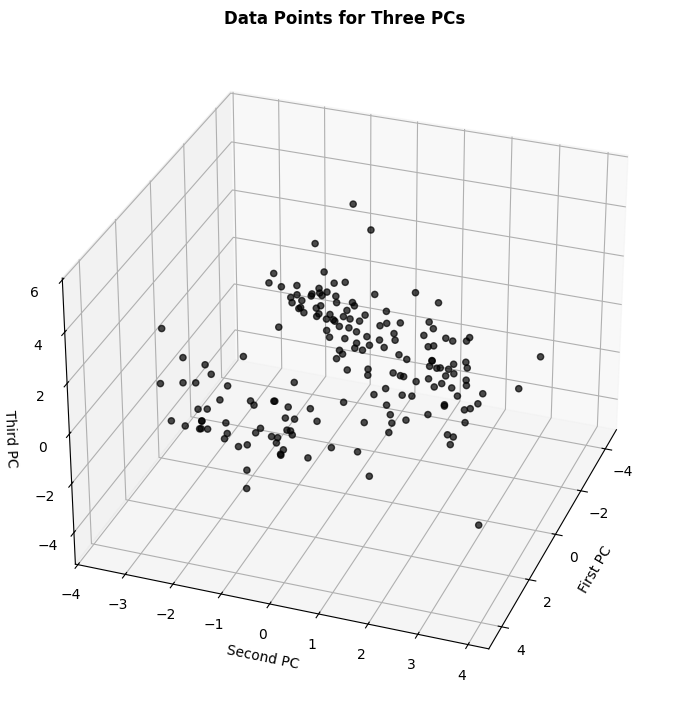

In [47]:
# Visualizing the transformed data
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], wine_data_pca[:, 2], c = 'black', alpha = 0.7)
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")
ax.view_init(elev = 30, azim = 20)
fig.tight_layout()
plt.title("Data Points for Three PCs", fontweight = 'bold')
plt.show()

From this plot, several clusters appear to be present in the data that might be detected using DBSCAN.

### DBSCAN Implementation
*Clustering using DBSCAN*

This section implements DBSCAN on the cleaned and transformed wine data to produce a set of clusters that adequately group samples. It carries out the model fit, labeling, visualization, and evaluation on several metrics.

The transformed data does not need to be further standardized, nor does it need to be split for unsupervised learning. We therefore begin by creating an instance of the `dbscan` class from the unsupervised learning package, and fitting it on the data.

This DBSCAN algorithm has the following specifications:
- **Epsilon:** 1
- **Number of Neighbors for a Core Point:** 6

In [48]:
# Creating and fitting the model
dbs = dbscan(1, 6)
dbs.fit(wine_data_pca)
labels = dbs.cluster_labels

Once the model has been created and fit, we can visualize the resulting clusters and evaluate performance.

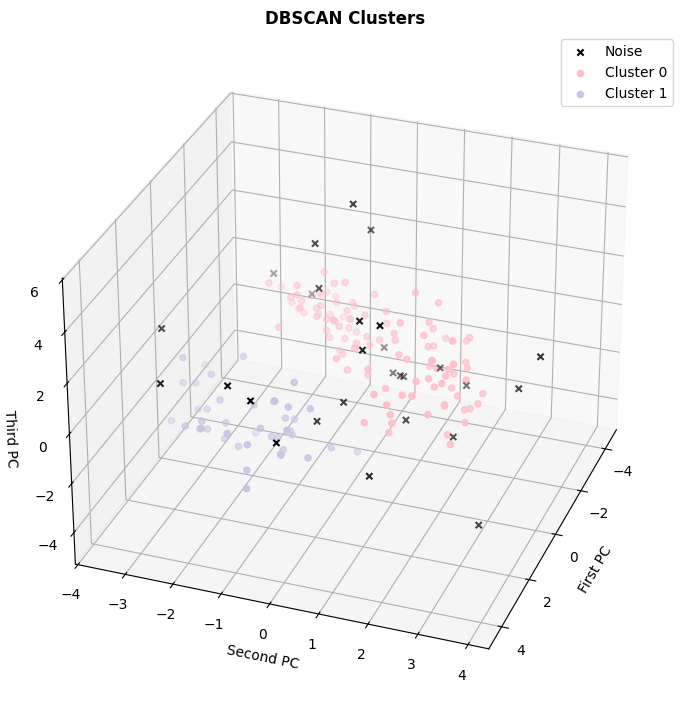

In [49]:
# Visualizing the transformed data with DBSCAN clusters
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels)
label_to_color = {0: 'pink', 1: '#CBC3E3', -1: 'black'}

for label in unique_labels:
    mask = (labels == label)
    color = label_to_color.get(label)  # fallback color just in case
    marker = 'x' if label == -1 else 'o'
    
    ax.scatter(
        wine_data_pca[mask, 0],
        wine_data_pca[mask, 1],
        wine_data_pca[mask, 2],
        c = color,
        marker = marker,
        label = f'Cluster {label}' if label != -1 else 'Noise'
    )
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")

ax.view_init(elev = 30, azim = 20)

ax.legend()
fig.tight_layout()

plt.title("DBSCAN Clusters", fontweight = 'bold')

plt.show()

In [50]:
# Evaluating the model on various metrics
n_clusters, n_noise, counts = evaluate_clusters(labels)
sil_score_false = silhouette_score(wine_data_pca, labels, ignore_noise = False)
sil_score_true = silhouette_score(wine_data_pca, labels, ignore_noise = True)
print(f"Silhouette score (with noise): {sil_score_false:.3f}")
print(f"Silhouette score (no noise): {sil_score_true:.3f}")

Cluster Evaluation Metrics:
---------------------------
Number of clusters: 2
Number of noise points: 28
Cluster counts (including noise as -1):
  Cluster 0.0: 106 points
  Cluster -1.0: 28 points
  Cluster 1.0: 44 points
Silhouette score (with noise): 0.274
Silhouette score (no noise): 0.447


The clusters appear to be a fairly good description of the data, with only around 28 points classified as noise and the remaining distributed across two clusters. However, these clusters do not have a particularly high silhouette score, especially when noise is factored into the analysis (0.48 and 0.30, respectively). This suggests that the clustering produced may not be the optimal division of the data. We will change the hyperparameters of the model to determine whether it benefits performance.

### DBSCAN Implementation (Changing Parameters)
*Altering epsilon and number of neighbors for core points*

This section implements the custom DBSCAN algorithm on the transformed data, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different values of epsilon (radius around a point that defines a neighborhood), using silhouette score as the primary metric.

In [51]:
# Arrays for epsilon and silhouette score
epsilon_array = np.linspace(0.5, 2, 15)
sil_scores_epsilon = []

# Finding silhouette score for values of epsilon
for i in range(len(epsilon_array)):
    dbs = dbscan(epsilon_array[i], 6)
    dbs.fit(wine_data_pca)
    labels = dbs.cluster_labels
    sil_score = silhouette_score(wine_data_pca, labels, ignore_noise = False)
    sil_scores_epsilon.append(sil_score)

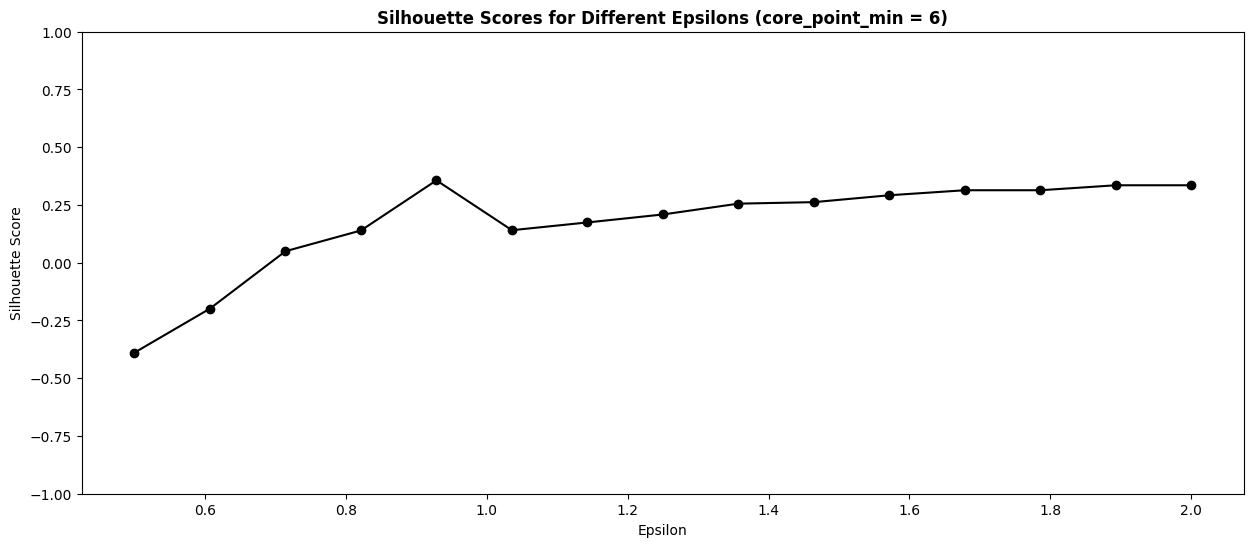

In [52]:
# Plotting the change in silhouette score across different epsilon values
plt.figure(figsize = (15, 6))
plt.plot(epsilon_array, sil_scores_epsilon, 'black')
plt.scatter(epsilon_array, sil_scores_epsilon, color = 'black')
plt.title("Silhouette Scores for Different Epsilons (core_point_min = 6)", fontweight = 'bold')
plt.xlabel("Epsilon")
plt.ylabel("Silhouette Score")
plt.ylim(-1, 1)
plt.show()

As epsilon increases, the silhouette score for the model generally increases as well, although this is most significant from a range of 0.5 to around 1.1. Beyond this, the effects on silhouette score are not large. In some cases, a slight decrease occurs at around 1.2, then increases again as epsilon moves to 2. For the remainder of this analysis, we will continue to use an epsilon of 1.

We now determine the effect of changing the minimum number of neighbors required to be a core point on silhouette score.

In [53]:
# Arrays for core point minimum and silhouette score
core_array = np.arange(1, 11)
sil_scores_core = []

# Calculating silhouette score for each core point minimum
for i in range(len(core_array)):
    dbs = dbscan(1, int(core_array[i]))
    dbs.fit(wine_data_pca)
    labels = dbs.cluster_labels
    sil_score = silhouette_score(wine_data_pca, labels, ignore_noise = False)
    sil_scores_core.append(sil_score)

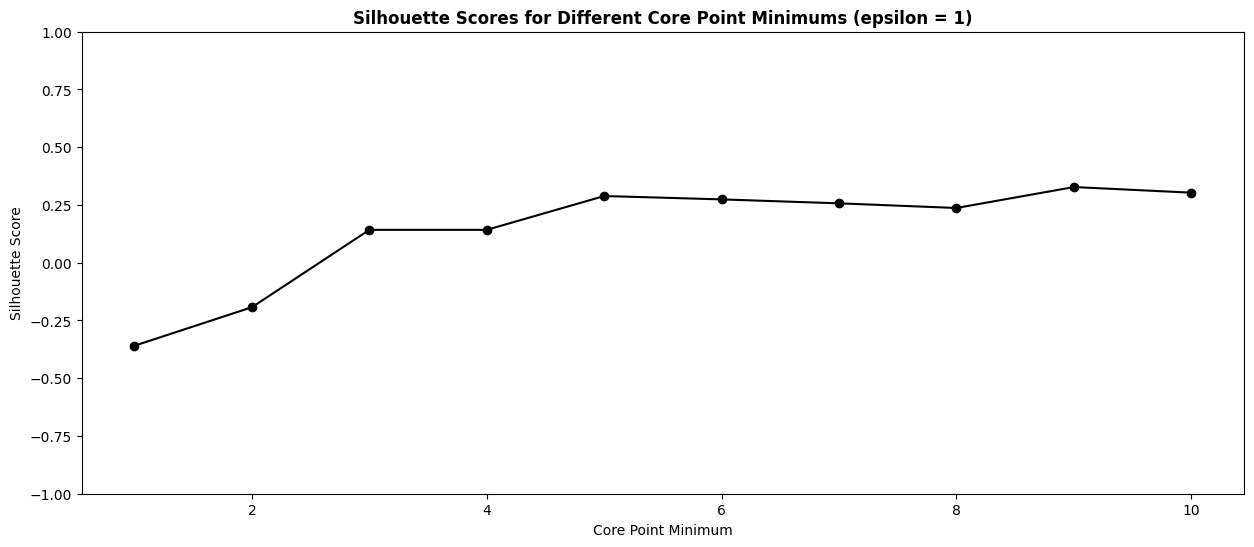

In [54]:
# Plotting the change in silhouette score across different core point minimum values
plt.figure(figsize = (15, 6))
plt.plot(core_array, sil_scores_core, 'black')
plt.scatter(core_array, sil_scores_core, color = 'black')
plt.title("Silhouette Scores for Different Core Point Minimums (epsilon = 1)", fontweight = 'bold')
plt.xlabel("Core Point Minimum")
plt.ylabel("Silhouette Score")
plt.ylim(-1, 1)
plt.show()

The silhouette score for this model generally increases as the number of neighbors required to classify a core point increases. However, it does not significantly improve the score after a value of around 3, instead resulting in a plateau. The silhouette score for this model remains fairly low regardless of the combinations, which may indicate that the data is not easily clustered. To validate the custom DBSCAN and ensure that the low score is not a consequence of incorrect model implementation, we compare it against existing algorithms.

### Comparison with Existing Models
*Comparison with scikit-learn DBSCAN*

In order to ensure that the custom-built DBSCAN is functioning as intended and providing expected results, it is useful to compare its performance to DBSCAN performed using established code. In this section, we rerun the analysis with all features using the scikit-learn DBSCAN with a matching epsilon (1) and minimum sample parameter (6) to verify the results of the custom model.


In [55]:
from sklearn.cluster import DBSCAN
dbscan_sk = DBSCAN(eps = 1, min_samples = 6)
dbscan_sk.fit(wine_data_pca)
labels_sk = dbscan_sk.labels_

In [56]:
n_clusters, n_noise, counts = evaluate_clusters(labels_sk)
sil_score_false = silhouette_score(wine_data_pca, labels_sk, ignore_noise = False)
sil_score_true = silhouette_score(wine_data_pca, labels_sk, ignore_noise = True)
print(f"Silhouette score (with noise): {sil_score_false:.3f}")
print(f"Silhouette score (no noise): {sil_score_true:.3f}")

Cluster Evaluation Metrics:
---------------------------
Number of clusters: 2
Number of noise points: 28
Cluster counts (including noise as -1):
  Cluster 0.0: 106 points
  Cluster -1.0: 28 points
  Cluster 1.0: 44 points
Silhouette score (with noise): 0.274
Silhouette score (no noise): 0.447


The scikit-learn DBSCAN results match those of the custom class, indicating that the custom DBSCAN is functioning as expected. The silhouette score (especially with noise) remains low, but because the two models produced equivalent results, this suggests that the data does not produce easily defined clusters rather than indicating an error in the custom DBSCAN implementation. Thus, the custom `rice_ml` DBSCAN is able to handle multi-feature clustering problems in a manner that matches professional-level code.